In [1]:
# przetwarzanie danych
import numpy as np
import pandas as pd

# przekształcanie – normalizacja danych
from sklearn.preprocessing import MinMaxScaler

# wizualizacja
import matplotlib.pyplot as plt

# sieci neuronowe
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU

# ewaluacja modelu
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('airline-passengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index(['Month'], inplace=True)
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [3]:
df=np.array(dataset)
train_and_val_size = int(len(dataset) * 0.70)
train_size = int(train_and_val_size * 0.70)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_function=scaler
rmse_dataframe = pd.DataFrame(columns = ['look_back', 'unit', 'RMSE'])

In [4]:
for lback in range(1,13):
    
    #granice dla przedziałów treningowego, walidacyjnego i testowego.
    #Końcówka zbioru walidacyjnego i początek testowego pokrywają się, żeby można było przewidywać początkowe wartości
    #dla zestawu testowego. Będzie to widoczne na końcu, na wykresie.
    
    test_size = len(df) - train_and_val_size
    test = df[train_and_val_size-lback-2:len(df),:].copy()
    train, val = df[0:train_size,:].copy(),df[train_size:train_and_val_size,:].copy()
    train = scaler_function.fit_transform(train)
    test = scaler_function.transform(test)
    val = scaler_function.transform(val)
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []

    # Tworzenie zbioru treninowego
    for i in range(len(train)-lback-1):
        a = train[i:(i+lback), 0]
        X_train.append(a)
        y_train.append(train[i + lback, 0])

    # Tworzenie zbioru walidacyjnego
    for i in range(len(val)-lback-1):
        a = val[i:(i+lback), 0]
        X_val.append(a)
        y_val.append(val[i + lback, 0])

    # Tworzenie zbioru testowego
    for i in range(len(test)-lback-1):
        a = test[i:(i+lback), 0]
        X_test.append(a)
        y_test.append(test[i + lback, 0])

    X_train, X_val,  X_test = np.array(X_train), np.array(X_val), np.array(X_test)
    X_train, X_val,  X_test = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])), np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])),np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)
    
    for unit in range(1,13):
        model_rnn = Sequential()
        model_rnn.add(SimpleRNN(5, input_shape=(1, lback)))
        model_rnn.add(Dense(unit))
        model_rnn.add(Dense(1))
        model_rnn.compile(loss='mean_squared_error', optimizer='adam')
        model_rnn.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1)
                
        prediction_train = scaler.inverse_transform(model_rnn.predict(X_train))
        prediction_train = pd.Series(prediction_train.flatten(),
                                    index=dataset.index[lback:len(prediction_train)+lback])
        prediction_val = scaler.inverse_transform(model_rnn.predict(X_val))
        prediction_val = pd.Series(prediction_val.flatten(),
                                    index=dataset.index[len(prediction_train)+(2*lback)+1:train_and_val_size-1])
        rmse = mean_squared_error(dataset.loc[prediction_val.index, :], prediction_val) ** 0.5
        rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},
                                                 ignore_index=True)

Epoch 1/200
68/68 [==============================] - 1s 3ms/step - loss: 0.0710
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 6/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 7/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 8/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 9/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 10/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 11/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 12/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 103/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 104/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 105/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 106/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 107/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 108/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 109/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 110/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 111/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 112/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 1s 2ms/step - loss: 0.1626
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0560
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0447
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0373
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0311
Epoch 6/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0246
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 8/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 9/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 10/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 11/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 12/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 103/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 104/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 105/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 106/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 107/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 108/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 110/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 112/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 1s 2ms/step - loss: 0.1173
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 6/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 9/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 10/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 11/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 12/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 103/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 104/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 105/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 106/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 107/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 108/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 109/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 110/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 111/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 112/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 40ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 3s 4ms/step - loss: 0.0547
Epoch 2/200
68/68 [==============================] - 0s 5ms/step - loss: 0.0209
Epoch 3/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 4/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 5/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 6/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 7/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 8/200
68/68 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 9/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 10/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 11/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 12/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 103/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 104/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 105/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 106/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 107/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 108/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 109/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 110/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 111/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 112/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 113/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 34ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 1s 3ms/step - loss: 0.9423
Epoch 2/200
68/68 [==============================] - 0s 3ms/step - loss: 0.3680
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.1969
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.1468
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.1229
Epoch 6/200
68/68 [==============================] - 0s 2ms/step - loss: 0.1035
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0865
Epoch 8/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0715
Epoch 9/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0582
Epoch 10/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0471
Epoch 11/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0377
Epoch 12/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0295
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 103/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 104/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 105/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 106/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 107/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 108/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 109/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 110/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 111/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 112/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 113/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 40ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 2s 3ms/step - loss: 0.1257
Epoch 2/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0345
Epoch 3/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 4/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 5/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 6/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 8/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 9/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 10/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 11/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 12/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 103/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 104/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 105/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 106/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 107/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 108/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 109/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 110/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 111/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 112/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 1s 2ms/step - loss: 0.1299
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 6/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 8/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 9/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 10/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 11/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 12/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 103/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 104/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 105/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 106/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 107/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 108/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 109/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 110/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 111/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 112/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 35ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 1s 2ms/step - loss: 0.0099
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 4/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 5/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 6/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 7/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 8/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 9/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 10/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 11/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 12/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 103/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 104/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 105/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 106/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 107/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 108/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 109/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 110/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 111/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 112/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 1s 2ms/step - loss: 0.0200
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 6/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 8/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 9/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 10/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 11/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 12/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 103/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 104/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 105/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 106/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 107/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 108/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 109/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 110/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 111/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 112/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 1s 2ms/step - loss: 0.0096
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 6/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 8/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 9/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 10/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 11/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 12/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 103/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 104/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 105/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 106/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 108/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 109/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 110/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 112/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 1s 2ms/step - loss: 0.0885
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 6/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 8/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 9/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 10/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 11/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 12/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 103/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 104/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 105/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 106/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 107/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 108/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 109/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 110/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 111/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 112/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 113/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 46ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
68/68 [==============================] - 2s 3ms/step - loss: 0.1270
Epoch 2/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0337
Epoch 3/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 4/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 5/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 6/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 8/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 9/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 10/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 11/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 12/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 103/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 104/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 105/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 106/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 107/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 108/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 110/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 111/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 112/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 114/200
68/68 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 1s 2ms/step - loss: 0.3154
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0818
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0557
Epoch 4/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0439
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 7/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 9/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 12/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 103/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 104/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 105/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 106/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 107/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 108/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 109/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 110/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 111/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 112/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 113/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 1s 2ms/step - loss: 0.2827
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.1040
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0573
Epoch 4/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0458
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0273
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 12/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 103/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 104/200
67/67 [==============================] - 0s 4ms/step - loss: 0.0084
Epoch 105/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 106/200
67/67 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 107/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 108/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 109/200
67/67 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 110/200
67/67 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 111/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 112/200
67/67 [==============================] - 0s 4ms/step - loss: 0.0083
Epoch 113/200
67/67 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 1s 2ms/step - loss: 0.2520
Epoch 2/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0717
Epoch 3/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0465
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0389
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0324
Epoch 6/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 7/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 12/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 103/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 104/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 105/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 106/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 107/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 108/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 110/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 112/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 113/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 34ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 2s 2ms/step - loss: 0.1607
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0466
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0247
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 8/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 9/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 10/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 12/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 103/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 104/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 105/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 106/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 107/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 108/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 109/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 110/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 111/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 112/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 113/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 2s 3ms/step - loss: 0.0312
Epoch 2/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 3/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 4/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 5/200
67/67 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 6/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 7/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 8/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 9/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 10/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 11/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 12/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 103/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 104/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 105/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 106/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 107/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 108/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 109/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 110/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 111/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 112/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 113/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 48ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 4/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 5/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 12/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 103/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 104/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 105/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 106/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 107/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 108/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 109/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 110/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 111/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 112/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 113/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 40ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 1s 2ms/step - loss: 0.0245
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 10/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 12/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 103/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 104/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 105/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 106/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 108/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 109/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 110/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 111/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 112/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 113/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 40ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 2s 3ms/step - loss: 0.0804
Epoch 2/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 3/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 4/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 7/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 9/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 12/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 103/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 104/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 105/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 106/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 107/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 108/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 109/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 110/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 112/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 113/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 1s 2ms/step - loss: 0.0720
Epoch 2/200
67/67 [==============================] - 0s 4ms/step - loss: 0.0215
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 8/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 11/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 12/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 103/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 104/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 105/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 106/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 107/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 108/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 109/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 110/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 111/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 112/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 113/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 1s 2ms/step - loss: 0.0265
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 4/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 5/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 6/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 7/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 8/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 9/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 10/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 11/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 12/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 103/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 104/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 105/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 106/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 107/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 108/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 109/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 110/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 111/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 112/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 113/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 2s 2ms/step - loss: 0.0126
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 12/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 103/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 104/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 105/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 106/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 107/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 108/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 109/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 110/200
67/67 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 111/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 112/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 113/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
67/67 [==============================] - 1s 2ms/step - loss: 0.0826
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 11/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 12/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 13/200
67/67 [=================

67/67 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 103/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 104/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 105/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 106/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 107/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 108/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 109/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 110/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 111/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 112/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 113/200
67/67 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 114/200
67/67 [=========

1/1 [==============================] - 0s 34ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 1s 2ms/step - loss: 0.0182
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 6/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 7/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 9/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 10/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 11/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 12/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 104/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 105/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 106/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 109/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 110/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 111/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 113/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 41ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 1s 3ms/step - loss: 0.1436
Epoch 2/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0564
Epoch 3/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0504
Epoch 4/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0448
Epoch 5/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0403
Epoch 6/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0350
Epoch 7/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0318
Epoch 8/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0293
Epoch 9/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0263
Epoch 10/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0243
Epoch 11/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 12/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 103/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 104/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 105/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 106/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 107/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 108/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 109/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 110/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 111/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 112/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 113/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 40ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 1s 2ms/step - loss: 0.0228
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 5/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 6/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 7/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 9/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 10/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 11/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 12/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 104/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 105/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 106/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 109/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 110/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 111/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 113/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 1s 2ms/step - loss: 0.5953
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 0.1182
Epoch 3/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0544
Epoch 4/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0438
Epoch 5/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0349
Epoch 6/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0269
Epoch 7/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 9/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 10/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 11/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 12/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 104/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 105/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 106/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 109/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 110/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 111/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 113/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 1s 2ms/step - loss: 0.3070
Epoch 2/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0855
Epoch 3/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0451
Epoch 4/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0381
Epoch 5/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0331
Epoch 6/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0277
Epoch 7/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0231
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 9/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 10/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 11/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 12/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 103/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 104/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 105/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 106/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 107/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 108/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 109/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 110/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 111/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 112/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 113/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 33ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 1s 3ms/step - loss: 0.0176
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 4/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 5/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 6/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 7/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 9/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 10/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 11/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 12/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 104/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 105/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 106/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 109/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 110/200
66/66 [==============================] - 1s 8ms/step - loss: 0.0089
Epoch 111/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 113/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 46ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 1s 2ms/step - loss: 0.0184
Epoch 2/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 5/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 6/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 7/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 8/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 9/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 10/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 11/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 12/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 104/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 105/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 106/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 109/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 110/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 111/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 112/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 113/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 2s 3ms/step - loss: 0.0200
Epoch 2/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 3/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 4/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 6/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 7/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 8/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 9/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 10/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 11/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 12/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 104/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 105/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 106/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 108/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 109/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 110/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 111/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 113/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 2s 3ms/step - loss: 0.2449
Epoch 2/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0471
Epoch 3/200
66/66 [==============================] - 0s 6ms/step - loss: 0.0335
Epoch 4/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0292
Epoch 5/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0242
Epoch 6/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0203
Epoch 7/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0175
Epoch 8/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 9/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 10/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 11/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 12/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 104/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 105/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 106/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 110/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 111/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 113/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 32ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


66/66 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 5/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 6/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 7/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 9/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 10/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 11/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 12/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 13/200
66/66 [=============================

66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 104/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 105/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 106/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 109/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 110/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 111/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 113/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 2s 2ms/step - loss: 0.0227
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 5/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 6/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 7/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 9/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 10/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 11/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 12/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 104/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 105/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 106/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 109/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 110/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 111/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 113/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
66/66 [==============================] - 1s 2ms/step - loss: 0.0152
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 5/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 6/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 7/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 9/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 10/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 11/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 12/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 104/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 105/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 106/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 109/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 110/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 111/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 113/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 114/200
66/66 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 1s 2ms/step - loss: 0.0212
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 8/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 10/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 11/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 12/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 103/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 104/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 105/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 106/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 108/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 109/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 110/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 112/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 113/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 1s 2ms/step - loss: 0.0508
Epoch 2/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0358
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0306
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0292
Epoch 8/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0285
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 10/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 11/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 12/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 103/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 104/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 105/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 106/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 107/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 108/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 109/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 110/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 111/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 112/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 113/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 1s 2ms/step - loss: 0.0230
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 10/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 11/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 12/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 103/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 104/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 105/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 106/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 107/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 108/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 109/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 110/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 111/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 112/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 113/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 2s 2ms/step - loss: 0.7708
Epoch 2/200
65/65 [==============================] - 0s 3ms/step - loss: 0.1565
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0834
Epoch 4/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 5/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0553
Epoch 6/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0456
Epoch 7/200
65/65 [==============================] - 0s 4ms/step - loss: 0.0383
Epoch 8/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0326
Epoch 9/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0279
Epoch 10/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 11/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 12/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 103/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 104/200
65/65 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 105/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 106/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 107/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 108/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 109/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 110/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 111/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 112/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 113/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 2s 3ms/step - loss: 0.2196
Epoch 2/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0754
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0568
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0510
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0462
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 8/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0309
Epoch 10/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 11/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 12/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 103/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 104/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 105/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 106/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 107/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 108/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 109/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 110/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 111/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 112/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 113/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 1s 2ms/step - loss: 0.5024
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 0.1016
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0516
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0421
Epoch 5/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 6/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 7/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0221
Epoch 8/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 10/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 11/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 12/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 103/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 104/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 105/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 106/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 107/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 108/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 109/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 110/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 111/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 112/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 113/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 1s 2ms/step - loss: 0.0827
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 8/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 10/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 11/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 12/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 103/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 104/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 105/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 106/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 107/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 108/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 109/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 110/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 111/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 112/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 113/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 1s 4ms/step - loss: 0.0228
Epoch 2/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 5/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 6/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 7/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 8/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 9/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 10/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 11/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 12/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 103/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 104/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 105/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 106/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 107/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 108/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 109/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 110/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 111/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 112/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 113/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 1s 2ms/step - loss: 0.2576
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0468
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0342
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 8/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 10/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 11/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 12/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 103/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 104/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 105/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 106/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 107/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 108/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 109/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 110/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 111/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 112/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 113/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 1s 3ms/step - loss: 0.3265
Epoch 2/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0550
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0366
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0304
Epoch 5/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 7/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 8/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 10/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 11/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 12/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 103/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 104/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 105/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 106/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 107/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 108/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 109/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 110/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 111/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 112/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 113/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 1s 3ms/step - loss: 0.2572
Epoch 2/200
65/65 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 4/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0224
Epoch 5/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 8/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 9/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 10/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 11/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 12/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 103/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 104/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 105/200
65/65 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 106/200
65/65 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 107/200
65/65 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 108/200
65/65 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 109/200
65/65 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 110/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 111/200
65/65 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 112/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 113/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
65/65 [==============================] - 2s 3ms/step - loss: 0.5578
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0767
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0365
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 8/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 9/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 10/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 11/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 12/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 13/200
65/65 [=================

65/65 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 103/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 104/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 105/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 106/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 107/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 108/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 109/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 110/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 111/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 112/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 113/200
65/65 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 114/200
65/65 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
64/64 [==============================] - 1s 2ms/step - loss: 0.1416
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0538
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0473
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0435
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0401
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0374
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0340
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 9/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0296
Epoch 10/200
64/64 [==============================] - 0s 4ms/step - loss: 0.0274
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 12/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 13/200
64/64 [=================

64/64 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 112/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 238ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
64/64 [==============================] - 1s 2ms/step - loss: 0.2143
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0865
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0716
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0669
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0619
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0559
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0521
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0500
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0454
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0450
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 13/200
64/64 [=================

64/64 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 103/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 111/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 112/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 297ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


64/64 [==============================] - 1s 2ms/step - loss: 0.2005
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0440
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0249
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 13/200
64/64 [=============================

64/64 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 103/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 112/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 257ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
64/64 [==============================] - 1s 2ms/step - loss: 0.0183
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 13/200
64/64 [=================

64/64 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 112/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 254ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


64/64 [==============================] - 1s 2ms/step - loss: 0.0594
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 13/200
64/64 [=============================

64/64 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 112/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 237ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
64/64 [==============================] - 1s 2ms/step - loss: 0.4400
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0731
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0394
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 13/200
64/64 [=================

64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 112/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 244ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
64/64 [==============================] - 1s 2ms/step - loss: 0.0482
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 13/200
64/64 [=================

64/64 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 112/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 213ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


64/64 [==============================] - 1s 2ms/step - loss: 0.3603
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0660
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0528
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0462
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0418
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0333
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0300
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0273
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 13/200
64/64 [=============================

64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 112/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 218ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


64/64 [==============================] - 1s 2ms/step - loss: 0.3621
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.1024
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0616
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0528
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0351
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 8/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 13/200
64/64 [=============================

64/64 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 112/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 223ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


64/64 [==============================] - 1s 2ms/step - loss: 0.0255
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 11/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 13/200
64/64 [=============================

64/64 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 111/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 112/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 207ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


64/64 [==============================] - 1s 3ms/step - loss: 0.0204
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 10/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 13/200
64/64 [=============================

64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 112/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 217ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
64/64 [==============================] - 1s 2ms/step - loss: 0.0512
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0301
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0246
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 8/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 9/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 10/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 11/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 12/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 13/200
64/64 [=================

64/64 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 103/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 104/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 105/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 106/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 107/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 108/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 109/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 110/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 111/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 112/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 113/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 114/200
64/64 [=========

1/1 [==============================] - 0s 259ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 1s 2ms/step - loss: 0.0964
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 7/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 103/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 104/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 105/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 36ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


63/63 [==============================] - 1s 2ms/step - loss: 3.2315
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 1.4110
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.5292
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 0.2390
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.1662
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.1452
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 0.1317
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.1196
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.1061
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0948
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0844
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0761
Epoch 13/200
63/63 [=============================

63/63 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 103/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 104/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 105/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 1s 2ms/step - loss: 0.2969
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0411
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0291
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 11/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 103/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 104/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 105/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 43ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 1s 2ms/step - loss: 0.0514
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0333
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0274
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 103/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 104/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 105/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 108/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 1s 2ms/step - loss: 1.2334
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 0.3993
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.1389
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0836
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0727
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0564
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0490
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0427
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0373
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 103/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 104/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 105/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 1s 2ms/step - loss: 0.0272
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 103/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 104/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 105/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 111/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 112/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 35ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 2s 3ms/step - loss: 0.0391
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 7/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 8/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 9/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 10/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 11/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 12/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 103/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 104/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 105/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 109/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 111/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 113/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 2s 3ms/step - loss: 0.0854
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0371
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0284
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0220
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 7/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 8/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 10/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 11/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 12/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 103/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 104/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 105/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 106/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 108/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 2s 2ms/step - loss: 0.1946
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0468
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0404
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0287
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0254
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 103/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 104/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 105/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 107/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 1s 2ms/step - loss: 0.0208
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 103/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 104/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 105/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 1s 2ms/step - loss: 0.3573
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0555
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0461
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0413
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0342
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0254
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 103/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 104/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 105/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 109/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 112/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
63/63 [==============================] - 1s 3ms/step - loss: 0.0635
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 7/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 8/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 9/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 10/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 12/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 13/200
63/63 [=================

63/63 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 103/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 104/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 105/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 106/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 107/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 108/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 109/200
63/63 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 110/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 111/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 112/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 113/200
63/63 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 114/200
63/63 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 3ms/step - loss: 0.3140
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0747
Epoch 3/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0418
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 6/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0318
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0300
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0249
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 103/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 105/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 106/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 107/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 110/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 111/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 112/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 113/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 40ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 2s 3ms/step - loss: 0.0254
Epoch 2/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0232
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 4/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 6/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0201
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 103/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 104/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.0514
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0246
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 103/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.2098
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0522
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0447
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0410
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0361
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0325
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0298
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0254
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 103/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 32ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.0389
Epoch 2/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0346
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 9/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 103/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 41ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.0553
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0419
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0365
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0310
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0258
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 103/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 35ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.0817
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0351
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 6/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 103/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 108/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.4108
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0717
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 4/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0443
Epoch 5/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0396
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0359
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0253
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 103/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.0493
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 3/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0201
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 103/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 108/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 111/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.0527
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0302
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 103/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.0728
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0283
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 103/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 111/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 0.0800
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0388
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0334
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 6/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 10/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 11/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 12/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 13/200
62/62 [=================

62/62 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 103/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 104/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 105/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 106/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 107/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 108/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 109/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 110/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 111/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 112/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 113/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 114/200
62/62 [=========

1/1 [==============================] - 0s 40ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.2341
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.1430
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0785
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0451
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0351
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0307
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0284
Epoch 12/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 44ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 2s 3ms/step - loss: 0.1254
Epoch 2/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0512
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0482
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0467
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0432
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 7/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0380
Epoch 9/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0359
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 12/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 112/200
61/61 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 46ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.2281
Epoch 2/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0583
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0492
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0435
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0396
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0324
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0288
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0273
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 12/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.1544
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0765
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0667
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0605
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0529
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0478
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0425
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0363
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0337
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0318
Epoch 12/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0291
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.3573
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0840
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0451
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0417
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0384
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0310
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0285
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0253
Epoch 12/200
61/61 [==============================] - 0s 4ms/step - loss: 0.0244
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.0426
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0408
Epoch 3/200
61/61 [==============================] - 0s 4ms/step - loss: 0.0317
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0249
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0216
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0216
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 12/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 43ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.1072
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0932
Epoch 3/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0788
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0741
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0645
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0533
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0495
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0455
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0432
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0404
Epoch 12/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0380
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.0572
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0274
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 12/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 105/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 113/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.0938
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0291
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 12/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 104/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 105/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 35ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.0209
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 8/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 10/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 11/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 12/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 34ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 2s 3ms/step - loss: 0.1984
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.1080
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0867
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0741
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0626
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0532
Epoch 7/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0488
Epoch 8/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0401
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 10/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0303
Epoch 11/200
61/61 [==============================] - 0s 5ms/step - loss: 0.0276
Epoch 12/200
61/61 [==============================] - 0s 4ms/step - loss: 0.0252
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 113/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
61/61 [==============================] - 1s 2ms/step - loss: 0.2453
Epoch 2/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0997
Epoch 3/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0746
Epoch 4/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0573
Epoch 5/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0432
Epoch 6/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0341
Epoch 7/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 8/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0220
Epoch 9/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 10/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 11/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 12/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 13/200
61/61 [=================

61/61 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 103/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 104/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 105/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 106/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 107/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 108/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 109/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 110/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 111/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 112/200
61/61 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 113/200
61/61 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 114/200
61/61 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.0556
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0210
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0201
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 9/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 12/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 105/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.2739
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0451
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0310
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0246
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 10/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 11/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 12/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 105/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.5928
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0686
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0542
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0475
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0338
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0287
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 12/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 113/200
60/60 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.9049
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.1600
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0776
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0692
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0621
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0559
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0499
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0454
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0374
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0342
Epoch 12/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 104/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 113/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 1.1525
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.2810
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0821
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0569
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0476
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0400
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0375
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0311
Epoch 12/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 110/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.0752
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0304
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0301
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0258
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 12/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0226
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 103/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 108/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.2132
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0493
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0406
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0309
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 12/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 4ms/step - loss: 0.0082
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 32ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.6674
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0903
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 12/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.1543
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0296
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0258
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0243
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 12/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.0319
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0234
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 10/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 11/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 12/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 112/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 37ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


60/60 [==============================] - 1s 2ms/step - loss: 0.1085
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0426
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0325
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0285
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 12/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 13/200
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 112/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 113/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
60/60 [==============================] - 1s 2ms/step - loss: 0.0196
Epoch 2/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 4/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 8/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 9/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 10/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 11/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 12/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 13/200
60/60 [=================

60/60 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 103/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 104/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 105/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 106/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 107/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 108/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 109/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 110/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 111/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 112/200
60/60 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 113/200
60/60 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 114/200
60/60 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 0.0325
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 13/200
59/59 [=================

59/59 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 103/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 104/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 105/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 0.1217
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0406
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 5/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 7/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 8/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0243
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 13/200
59/59 [=================

59/59 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 103/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 104/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 33ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


59/59 [==============================] - 1s 2ms/step - loss: 0.7012
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.1891
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0703
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0532
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0491
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0456
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 8/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0371
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0311
Epoch 13/200
59/59 [=============================

59/59 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 103/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 104/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 0.1432
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0419
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0310
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0247
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 13/200
59/59 [=================

59/59 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 103/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 104/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 35ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 0.0634
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 13/200
59/59 [=================

59/59 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 103/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 104/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 33ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


59/59 [==============================] - 1s 2ms/step - loss: 0.3317
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0568
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0298
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0273
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 13/200
59/59 [=============================

59/59 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 103/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 104/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 0.1746
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 6/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0325
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 8/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0254
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 13/200
59/59 [=================

59/59 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 103/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 104/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 112/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 37ms/step
Epoch 1/200


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


59/59 [==============================] - 1s 2ms/step - loss: 0.1022
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0410
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0394
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 13/200
59/59 [=============================

59/59 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 103/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 104/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 105/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 106/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 107/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 108/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 110/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 111/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 0.0719
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0247
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 12/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 13/200
59/59 [=================

59/59 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 103/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 104/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 0.0328
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0233
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 10/200
59/59 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 13/200
59/59 [=================

59/59 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 103/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 104/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 107/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 108/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 111/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 44ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 0.3287
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0485
Epoch 3/200
59/59 [==============================] - 0s 3ms/step - loss: 0.0393
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0345
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0291
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 13/200
59/59 [=================

59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 103/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 104/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
59/59 [==============================] - 1s 2ms/step - loss: 0.0269
Epoch 2/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 6/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 8/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 9/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 10/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 11/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 12/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 13/200
59/59 [=================

59/59 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 103/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 104/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 105/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 106/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 107/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 108/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 109/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 110/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 111/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 112/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 113/200
59/59 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 114/200
59/59 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 1s 2ms/step - loss: 0.1946
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1043
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0481
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0285
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 103/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 104/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 105/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 110/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 111/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 112/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 113/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 1s 2ms/step - loss: 0.2982
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0915
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0363
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 12/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 103/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 104/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 105/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 107/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 110/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 111/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 112/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 1s 2ms/step - loss: 1.8655
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.2949
Epoch 3/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1192
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1018
Epoch 5/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0905
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0811
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0735
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0652
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0592
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0544
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0482
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 103/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 104/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 105/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 110/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 111/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 112/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 1s 2ms/step - loss: 0.0307
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 103/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 104/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 105/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 110/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 111/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 112/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 2s 4ms/step - loss: 0.0359
Epoch 2/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 6/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 10/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 103/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 104/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 105/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 110/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 111/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 112/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 1s 3ms/step - loss: 0.1047
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 4/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 5/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 6/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 103/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 104/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 105/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 106/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 110/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 111/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 112/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 113/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 1s 2ms/step - loss: 0.0651
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 6/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 9/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 12/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 103/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 104/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 105/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 110/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 111/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 112/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 1s 2ms/step - loss: 0.4200
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0762
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0565
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0461
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0380
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0325
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0287
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 103/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 104/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 105/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 110/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 111/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 112/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 1s 2ms/step - loss: 0.1112
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0655
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0567
Epoch 4/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0414
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 103/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 104/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 105/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 110/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 111/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 112/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 2s 3ms/step - loss: 0.1310
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 3/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0284
Epoch 4/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 103/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 104/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 105/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 106/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 107/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 108/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 109/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 110/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 111/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 112/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 34ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 2s 3ms/step - loss: 0.3427
Epoch 2/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0433
Epoch 3/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0374
Epoch 4/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0341
Epoch 5/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0303
Epoch 6/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0280
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 10/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 11/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 103/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 104/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 105/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 106/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 107/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 108/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 109/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 110/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 111/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 112/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 113/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 40ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
58/58 [==============================] - 1s 3ms/step - loss: 0.1718
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 3/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0294
Epoch 4/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0260
Epoch 5/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 6/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0224
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 8/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 9/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 10/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 11/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 12/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 13/200
58/58 [=================

58/58 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 103/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 104/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 105/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 107/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 108/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 109/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 110/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 111/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 112/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 113/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 114/200
58/58 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 2s 3ms/step - loss: 0.2250
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0814
Epoch 3/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 4/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 5/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 6/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 8/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 9/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 11/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 12/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 104/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 107/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 109/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 110/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 111/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 112/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 113/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 1s 2ms/step - loss: 0.3001
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0841
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0324
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 5/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 7/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 10/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 11/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 12/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 107/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 109/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 110/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 111/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 1s 2ms/step - loss: 0.1432
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0887
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0704
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0603
Epoch 5/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0530
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0474
Epoch 7/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0421
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0384
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0346
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 11/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0283
Epoch 12/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 107/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 109/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 110/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 111/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 39ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 1s 2ms/step - loss: 0.0924
Epoch 2/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0592
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0375
Epoch 5/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0298
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 7/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 11/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 12/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 107/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 109/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 110/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 111/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 46ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 2s 2ms/step - loss: 0.1907
Epoch 2/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0519
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0457
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 5/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0351
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 11/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 12/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 107/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 109/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 110/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 111/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 1s 2ms/step - loss: 0.0214
Epoch 2/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 5/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 7/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 11/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 12/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 107/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 109/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 110/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 111/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 2/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 5/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 7/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 11/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 12/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 107/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 109/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 110/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 111/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 40ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 2s 2ms/step - loss: 0.1079
Epoch 2/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0794
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0562
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0445
Epoch 5/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0370
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0302
Epoch 7/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 11/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 12/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 107/200
57/57 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 108/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 109/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 110/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 111/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 112/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 113/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 36ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 2s 2ms/step - loss: 0.0798
Epoch 2/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 5/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 7/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 11/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 12/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 107/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 109/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 110/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 111/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 35ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 1s 2ms/step - loss: 0.0899
Epoch 2/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 5/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 7/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 11/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 12/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 104/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 105/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 107/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 108/200
57/57 [==============================] - 1s 22ms/step - loss: 0.0031
Epoch 109/200
57/57 [==============================] - 1s 12ms/step - loss: 0.0032
Epoch 110/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 111/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 114/200
57/57 [=======

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 1s 2ms/step - loss: 0.0517
Epoch 2/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0233
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 5/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 8/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 9/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 10/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 11/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 12/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 107/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 109/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 110/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 111/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 38ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


Epoch 1/200
57/57 [==============================] - 1s 2ms/step - loss: 0.0317
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 3/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 4/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 5/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 6/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 7/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 10/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 11/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 12/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 13/200
57/57 [=================

57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 103/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 104/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 105/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 106/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 107/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 108/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 109/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 110/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 111/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 112/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 113/200
57/57 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 114/200
57/57 [=========

1/1 [==============================] - 0s 37ms/step


C:\Users\kulin\AppData\Local\Temp\ipykernel_37544\1201687654.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rmse_dataframe = rmse_dataframe.append({'look_back': lback, 'unit': unit, 'RMSE': rmse},


In [5]:
rmse_dataframe

,look_back,unit,RMSE
0,1.0,1.0,40.283101
1,1.0,2.0,42.942179
2,1.0,3.0,37.019745
3,1.0,4.0,45.015968
4,1.0,5.0,42.080186
...,...,...,...
139,12.0,8.0,87.283329
140,12.0,9.0,86.324115
141,12.0,10.0,76.927382
142,12.0,11.0,81.078703


In [6]:
minimum = (rmse_dataframe['RMSE'].idxmin())
lback, unit, rmse = rmse_dataframe.loc[minimum]
lback = int(lback)
unit = int(unit)
print(f'Najmniejsze RMSE wynosi {rmse}, a parametry dla tego modelu to lback={lback}, a unit={unit}')

Najmniejsze RMSE wynosi 31.99269356220239, a parametry dla tego modelu to lback=3, a unit=6


In [7]:
#tworzenie zbiorów dla wybranego parametru lback

df=np.array(dataset)
train_and_val_size = int(len(dataset) * 0.70)
train_size = int(train_and_val_size * 0.70)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_function=scaler

test_size = len(df) - train_and_val_size
test = df[train_and_val_size-lback-2:len(df),:].copy()
train, val = df[0:train_size,:].copy(),df[train_size:train_and_val_size,:].copy()

train = scaler_function.fit_transform(train)
test = scaler_function.transform(test)
val = scaler_function.transform(val)
X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []

# Tworzenie zbioru treninowego
for i in range(len(train)-lback-1):
    a = train[i:(i+lback), 0]
    X_train.append(a)
    y_train.append(train[i + lback, 0])

# Tworzenie zbioru walidacyjnego
for i in range(len(val)-lback-1):
    a = val[i:(i+lback), 0]
    X_val.append(a)
    y_val.append(val[i + lback, 0])

# Tworzenie zbioru testowego
for i in range(len(test)-lback-1):
    a = test[i:(i+lback), 0]
    X_test.append(a)
    y_test.append(test[i + lback, 0])

X_train, X_val,  X_test = np.array(X_train), np.array(X_val), np.array(X_test)
X_train, X_val,  X_test = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])), np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])),np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)


#tworzenie modelu dla wybranego parametru unit

model_rnn = Sequential()
model_rnn.add(SimpleRNN(5, input_shape=(1, lback)))
model_rnn.add(Dense(unit))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1)
prediction_train = scaler.inverse_transform(model_rnn.predict(X_train))
prediction_train = pd.Series(prediction_train.flatten(),
                            index=dataset.index[lback:len(prediction_train)+lback])
prediction_val = scaler.inverse_transform(model_rnn.predict(X_val))
prediction_val = pd.Series(prediction_val.flatten(),
                            index=dataset.index[len(prediction_train)+(2*lback)+1:train_and_val_size-1])
prediction_test = scaler.inverse_transform(model_rnn.predict(X_test))
prediction_test = pd.Series(prediction_test.flatten(),
                            index=dataset.index[train_and_val_size-2:len(dataset)-1])

Epoch 1/200
66/66 [==============================] - 2s 6ms/step - loss: 0.2780
Epoch 2/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0467
Epoch 3/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0335
Epoch 4/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0264
Epoch 5/200
66/66 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 6/200
66/66 [==============================] - 0s 4ms/step - loss: 0.0173
Epoch 7/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 9/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 10/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 11/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 12/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 13/200
66/66 [=================

66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 103/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 104/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 105/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 106/200
66/66 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 107/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 108/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 109/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 110/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 111/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 112/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 113/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 114/200
66/66 [=========

2/2 [==============================] - 0s 5ms/step


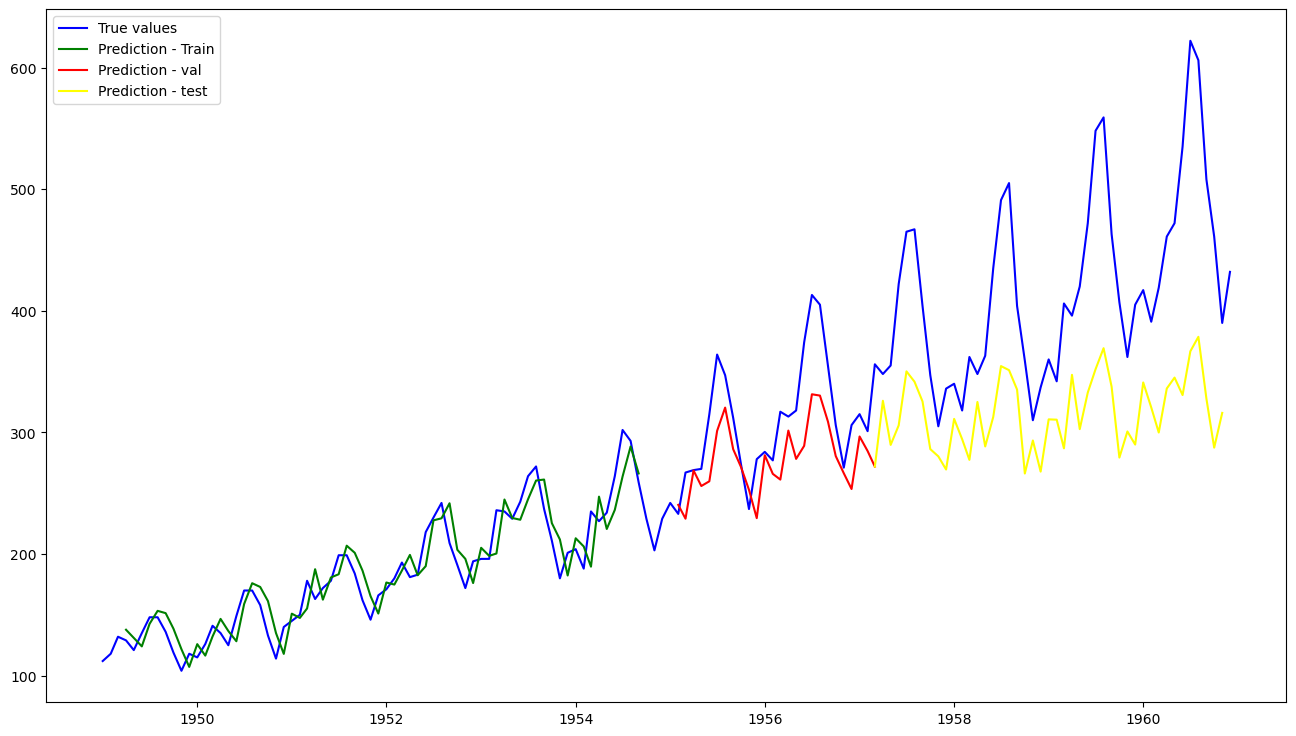


RMSE TEST: 117.31863722499696


In [9]:
# wizualizacja prognozy
plt.figure(figsize=(16,9))
plt.plot(dataset['Passengers'], color='blue', label='True values')
plt.plot(prediction_train, color='green', label='Prediction - Train')
plt.plot(prediction_val, color='red', label='Prediction - val')
plt.plot(prediction_test, color='yellow', label='Prediction - test')
plt.legend(loc='upper left')
plt.show()

rmse = mean_squared_error(dataset.loc[prediction_test.index, :], prediction_test) ** 0.5
print(f'\nRMSE TEST: {rmse}')

### Wnioski

Ze względu na pomniejszenie zbioru treningowego o wydzielony zbiór walidacyjny - prognoza jest słaba. Nie udało się nauczyć modelu coraz większej rozpiętości wartości.